In [1]:
import requests
import json
import os
import sys
import pandas as pd
import logging
from urllib.parse import urlencode
import time
from datetime import timedelta, datetime

In [2]:
def get_unix_time(days_ago=0):   
    """
    Convert days_ago to a unix timestamp
    
    Parameters:
    days_ago (int): Number of days in the past
    
    Returns:
    int: Unix timestamp for the date that was 'days_ago' days ago
    """
    current_time = int(time.time())
    seconds_ago = int(timedelta(days=days_ago).total_seconds())
    return current_time - seconds_ago

def get_time_delta(min_unix_time,max_time):
    """Returns string for url if short=False, else just the int"""
    min_unix_time = int(time.time()) #current time
    return (int(min_unix_time - timedelta(days=max_time).total_seconds()))

In [3]:
def fetch_match_data(
    min_average_badge: int = 100,
    max_unix_timestamp: int | None = None,
    min_unix_timestamp: int | None = None,
    m_id: str | None = None,
    include_player_info: bool = True,
    limit: int = 1000
    ) -> json:
    """Fetches match data from the Deadlock API.
    
    Key Parameters:
    - min_average_badge: Minimum average rank to return matches.
    - max_unix_timestamp: Newest time to filter matches. i.e. matches before yesterday
    - min_unix_timestamp: Oldest time to filter matches. i.e. matches 3 months ago -> max time
    - m_id: Specific match ID to fetch metadata for.
    - include_player_info: Whether to include player information in the response. this is required for match_player data
    - limit: Maximum number of matches to return.
    Returns:
    - JSON response containing match metadata with 12 players per match.
    """

    logging.debug(f"Fetching match data..")
    base = "https://api.deadlock-api.com/v1/matches"

    # if a specific match ID is given, check player_data and hit that endpoint
    if m_id:
        path = f"{base}/{m_id}/metadata"
        params = {}
        if include_player_info:
            params["include_player_info"] = "true"

        query = urlencode(params)
        full_url = f"{path}?{query}" if query else path
        response = requests.get(full_url)
        if response.status_code != 200:
            print(f"Error: API request failed with status code {response.status_code}")
            print(f"URL: {full_url}")
            return {"error": f"API request failed with status code {response.status_code}"}
        return response.json()

    # Bulk-metadata endpoint
    path = f"{base}/metadata"
    params: dict[str, str] = {}

    if include_player_info:
        params["include_player_info"] = "true"
    
    # Convert days to unix timestamps - ensure max is newer (smaller days_ago) than min
    if min_unix_timestamp is not None:
        older_time = get_unix_time(min_unix_timestamp)
        params["min_unix_timestamp"] = str(older_time)
    if max_unix_timestamp is not None:
        newer_time = get_unix_time(max_unix_timestamp)
        params["max_unix_timestamp"] = str(newer_time)
        
        # Debug info for timestamps
        print(f"Time range: {max_unix_timestamp} days ago to {min_unix_timestamp} days ago")
        print(f"Unix timestamps: {newer_time} to {older_time}")
        
    if min_average_badge is not None:
        params["min_average_badge"] = str(min_average_badge)
    if limit is not None:
        params["limit"] = str(limit)

    query = urlencode(params)
    full_url = f"{path}?{query}" if query else path
    
    print(f"Making request to: {full_url}")
    response = requests.get(full_url)
    if response.status_code != 200:
        print(f"Error: API request failed with status code {response.status_code}")
        print(f"URL: {full_url}")
        return {"error": f"API request failed with status code {response.status_code}"}
    return response.json()

In [4]:
# Test fetching a few matches
data = fetch_match_data(limit=10)
data

Making request to: https://api.deadlock-api.com/v1/matches/metadata?include_player_info=true&min_average_badge=100&limit=10


[{'average_badge_team0': 102,
  'average_badge_team1': 102,
  'duration_s': 1267,
  'game_mode': 'Normal',
  'game_mode_version': None,
  'is_high_skill_range_parties': False,
  'low_pri_pool': False,
  'match_id': 28627568,
  'match_mode': 'Unranked',
  'match_outcome': 'TeamWin',
  'new_player_pool': False,
  'players': [{'abandon_match_time_s': 0,
    'ability_points': 20,
    'account_id': 100051626,
    'assigned_lane': 3,
    'assists': 9,
    'deaths': 3,
    'denies': 10,
    'hero_id': 19,
    'kills': 10,
    'last_hits': 94,
    'net_worth': 21578,
    'party': 1,
    'player_level': 25,
    'player_slot': 9,
    'team': 'Team1'},
   {'abandon_match_time_s': 0,
    'ability_points': 22,
    'account_id': 91308342,
    'assigned_lane': 4,
    'assists': 10,
    'deaths': 5,
    'denies': 13,
    'hero_id': 12,
    'kills': 8,
    'last_hits': 150,
    'net_worth': 27204,
    'party': 0,
    'player_level': 27,
    'player_slot': 11,
    'team': 'Team1'},
   {'abandon_match_ti

In [5]:
def bulk_fetch_matches(max_days_fetch=90, min_days=3, max_days=0)->list:
    """fetches a batch of matches, 1 day per pull, list of jsons, 1 element per batch.

    batch is unnormalized, 'players' contains a df of each matches 'players'
    
    limit = max matches within a day to pull
    min_days = Oldest time barrier (more days ago)
    max_days = Newest time barrier (fewer days ago)
    max_days_fetch = max days to fetch, starting from max_days
    
    example:
    bulk_fetch_matches(max_days_fetch=30, min_days=7, max_days=0)
    will fetch data in one-day increments, from today back to 7 days ago,
    or until 30 days of data have been fetched.
    """

    limit = 500
    batch_matches = []
    
    # Calculate the starting day (defaults to today)
    current_max = max_days      # Newer boundary (fewer days ago)
    current_min = current_max + 1  # Older boundary (more days ago)
    
    for batch in range(max_days_fetch):
        logging.debug(f"\nBatch {batch}: fetching day from {current_max} to {current_min} days ago")
        print(f"DEBUG: Fetching matches for day {batch + 1} from {current_max} to {current_min} days ago")
        
        # Note: API expects min_unix_timestamp to be OLDER than max_unix_timestamp
        fetched_matches = fetch_match_data(
            min_unix_timestamp=current_min,  # Older timestamp (more days ago)
            max_unix_timestamp=current_max,  # Newer timestamp (fewer days ago)
            limit=limit
        )
        
        # Check if there was an error in the API response
        if "error" in fetched_matches:
            print(f"Error encountered during batch {batch+1}. Skipping this batch.")
        else:
            batch_matches.append(fetched_matches)
            
        # Move backward in time by one day
        current_max += 1  # Increase days ago for newer boundary
        current_min += 1  # Increase days ago for older boundary
        
        # Stop if we've reached the minimum days boundary
        if current_max >= min_days:
            print(f"Reached configured minimum day boundary ({min_days} days ago)")
            break

    return batch_matches

In [6]:
# Test fetching a bulk set of matches. badge > 100, yesterday -> 3 days ago.
# Data is a list of matches

print("Testing fixed bulk fetch - getting data from today to 3 days ago")
data = bulk_fetch_matches(max_days_fetch=4, min_days=3, max_days=0)
# Show how many matches in each day
for i, day_data in enumerate(data):
    if "error" in day_data:
        print(f"Day {i}: Error")
    else:
        print(f"Day {i}: {len(day_data)} matches")
print(f"data = {data}")

Testing fixed bulk fetch - getting data from today to 3 days ago
DEBUG: Fetching matches for day 1 from 0 to 1 days ago
Time range: 0 days ago to 1 days ago
Unix timestamps: 1754975699 to 1754889299
Making request to: https://api.deadlock-api.com/v1/matches/metadata?include_player_info=true&min_unix_timestamp=1754889299&max_unix_timestamp=1754975699&min_average_badge=100&limit=500
DEBUG: Fetching matches for day 2 from 1 to 2 days ago
Time range: 1 days ago to 2 days ago
Unix timestamps: 1754889299 to 1754802899
Making request to: https://api.deadlock-api.com/v1/matches/metadata?include_player_info=true&min_unix_timestamp=1754802899&max_unix_timestamp=1754889299&min_average_badge=100&limit=500
DEBUG: Fetching matches for day 3 from 2 to 3 days ago
Time range: 2 days ago to 3 days ago
Unix timestamps: 1754802900 to 1754716500
Making request to: https://api.deadlock-api.com/v1/matches/metadata?include_player_info=true&min_unix_timestamp=1754716500&max_unix_timestamp=1754802900&min_averag

In [7]:
for idx, d in enumerate(data):
    print(f"Day {idx}:")
    for match in d:
        print(f"  Match ID: {match['match_id']}, Players: {[player['account_id'] for player in match['players']]}")


Day 0:
  Match ID: 38707530, Players: [1924441699, 124024173, 1048356191, 381952778, 1395432137, 1902828658, 1482595800, 1176357514, 192227354, 1730032433, 1807540716, 1837991471]
  Match ID: 38707625, Players: [173322536, 1801488253, 880879950, 456104736, 25766064, 1118515282, 168805287, 1914755214, 145596499, 1906130552, 1907568183, 1067915524]
  Match ID: 38707818, Players: [1423690634, 1255354474, 1548096050, 202835210, 1610906733, 133417332, 195071239, 1739228765, 298155885, 130143991, 1698289940, 201404511]
  Match ID: 38707829, Players: [447351206, 896909867, 108815945, 1926422616, 66649287, 302685578, 475936398, 1273149256, 1807540716, 1924441699, 387885975, 1902828658]
  Match ID: 38707893, Players: [381952778, 1482595800, 393467885, 1730032433, 395566021, 1773696253, 1395432137, 861470542, 1048356191, 124024173, 192227354, 1837991471]
  Match ID: 38708129, Players: [1895769361, 1118515282, 1857189550, 9398369, 1857173892, 1150269374, 1115796992, 924969004, 1855172408, 1688052

In [8]:
# identify unique players in matches
unique_players = set()
for d in data:
    for match in d:
        unique_players.update(player['account_id'] for player in match['players'])
print(f"Unique players identified: {unique_players}")

Unique players identified: {366829568, 65552385, 1743454214, 1877508105, 1055031308, 1844731916, 1911644178, 165560339, 105553938, 16318483, 27992086, 173907991, 123502615, 1090412566, 153149464, 1837383713, 1238974498, 127942689, 1132011566, 431104049, 31555634, 388251702, 445177910, 85475388, 1028137021, 405946428, 37036096, 172638273, 339976259, 1776173125, 404054090, 327532620, 1900535887, 280649808, 145596499, 91373654, 1747017815, 1926422616, 143073372, 1875697758, 919887968, 1164034146, 318619753, 333815918, 111820919, 892272759, 64618621, 65650814, 58826881, 241565825, 327114883, 167698564, 1159381125, 884850823, 1700511880, 1834778761, 1906942092, 386039958, 50102427, 1905229981, 414269598, 354353309, 153706657, 1210056867, 195215525, 1599733928, 300523689, 355049645, 1150943406, 404144306, 338321587, 343515318, 240926906, 1883365566, 294387909, 1185906890, 1631346892, 200057040, 395034833, 385482964, 41238741, 169631959, 1711030490, 1196875996, 445120743, 981508327, 169453182

In [9]:
def seperate_match_players(
        matches_grouped_by_day: dict) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Normalizes bulk match data into two dataframes: matches and players."""

    logging.info("Normalizing bulk match data")
    matches = []
    players = []
    if not matches_grouped_by_day:
        logging.warning("No match data found — matches_grouped_by_day is empty.")
        return pd.DataFrame(), pd.DataFrame()
    for day_idx, day_matches in enumerate(matches_grouped_by_day): #day = key, match = value
        logging.info(f"Processing day #{day_idx} with {len(day_matches)} matches")
        
        for match in day_matches: # match: day = key: value | match_id: 7432551
            try:
                match_id = match["match_id"]
                start_time = match["start_time"]
                game_mode = match["game_mode"]
                match_mode = match["match_mode"]
                duration_s = match["duration_s"]
                winning_team = match["winning_team"]
            except KeyError as e:
                logging.error(f"Match missing key {e}: {match.get('match_id', 'unknown')}", exc_info=True)
                continue

            # Append to matches list
            matches.append({
                "match_id": match_id, # PK
                "start_time": start_time,
                "game_mode": game_mode,
                "match_mode": match_mode,
                "duration_s": duration_s,
                "winning_team": winning_team
            })
            
            # Append each player to players list
            if "players" not in match or len(match["players"]) != 12:
                logging.error(f"Match {match.get('match_id', 'unknown')} has invalid player count: {len(match.get('players', []))}")
                continue
            for player in match["players"]: # player: match["players"] = key: value | player_id: 1234567
                try:
                    players.append({
                        "account_id": player["account_id"],
                        "match_id": match_id,
                        "team": player["team"],
                        "hero_id": player["hero_id"],
                        "kills": player["kills"],
                        "deaths": player["deaths"],
                        "assists": player["assists"],
                        "denies": player["denies"],
                        "net_worth": player["net_worth"],
                    })
                except KeyError as e:
                    logging.error(f"Player missing key {e}: {player.get('account_id', 'unknown')}", exc_info=True)
                    continue

    # Convert lists to DataFrames
    df_matches = pd.DataFrame(matches)
    df_players = pd.DataFrame(players)
    if not matches:
        logging.warning("No matches appended — matches list is empty.")
    if not players:
        logging.warning("No players appended — players list is empty.")

    return df_matches, df_players

In [10]:
# Run data through normalization
matches, players = seperate_match_players(data)

# Add win column to players DataFrame
if not matches.empty and not players.empty:
    players = players.merge(
        matches[['match_id', 'winning_team']],
        on='match_id',
        how='left'
    )
    players['win'] = players.apply(
        lambda row: 'Y' if row['team'] == row['winning_team'] else 'N',
        axis=1
    )
    # Optionally, drop 'winning_team' if not needed:
    # players = players.drop(columns=['winning_team'])

print(f"matches: {matches}")
print(f"players: {players}")
print(f"matches: {matches}")
print(f"players: {players}")

matches:      match_id           start_time game_mode match_mode  duration_s  \
0    38707530  2025-08-11 05:35:24    Normal   Unranked        1347   
1    38707625  2025-08-11 05:42:39    Normal   Unranked        1988   
2    38707818  2025-08-11 05:58:16    Normal   Unranked        1937   
3    38707829  2025-08-11 05:58:55    Normal   Unranked        1351   
4    38707893  2025-08-11 06:03:43    Normal   Unranked        2012   
..        ...                  ...       ...        ...         ...   
704  38676565  2025-08-10 04:50:49    Normal   Unranked        1930   
705  38676681  2025-08-10 04:56:50    Normal   Unranked        1775   
706  38676702  2025-08-10 04:57:56    Normal   Unranked        1518   
707  38676863  2025-08-10 05:07:49    Normal   Unranked        2215   
708  38676961  2025-08-10 05:13:56    Normal   Unranked        1500   

    winning_team  
0          Team0  
1          Team1  
2          Team0  
3          Team0  
4          Team1  
..           ...  
704  

### Removing duplicates at this stage was the incorrect choice. Currently, stats are shown at the player<>match level, dropping duplicate rows removes that players stats for that game.

In [11]:
# # Remove duplicate account_ids so each is unique in players DataFrame
# rows_before = len(players)
# players_unique = players.drop_duplicates(subset=['account_id'], keep='first')
# rows_after = len(players_unique)
# rows_dropped = rows_before - rows_after
# print(f"Rows before: {rows_before}")
# print(f"Rows after: {rows_after}")
# print(f"Rows dropped: {rows_dropped}")
# print("Players DataFrame with unique account_id:")
# print(players_unique)

In [12]:
matches.to_csv("v2_data/matches.csv", index=False)
players.to_csv("v2_data/players.csv", index=False)

In [33]:
def fetch_player_hero_stats(account_id) -> dict:
    """Fetches hero stats for a specific player from the Deadlock API.
    
    Parameters:
    - account_id: Player's account ID to fetch stats for (can be string or numeric)
    
    Returns:
    - JSON response containing player's hero stats or error dict
    """
    
    base = "https://api.deadlock-api.com/v1/players"
    
    # Convert to string if it's not already
    account_id_str = str(account_id)
    
    path = f"{base}/{account_id_str}/hero-stats"
    
    try:
        print(f"Fetching stats for player {account_id_str}")
        response = requests.get(path)
        if response.status_code != 200:
            print(f"Error: API request failed for player {account_id_str} with status code {response.status_code}")
            print(f"Response: {response.text}")
            return {"error": f"API request failed with status code {response.status_code}"}
        return response.json()
    except Exception as e:
        print(f"Exception fetching hero stats for player {account_id_str}: {e}")
        return {"error": str(e)}

In [34]:
# Test the fetch_player_hero_stats function with a single player ID
if len(unique_players) > 0:
    # Get a sample player ID
    test_player_id = list(unique_players)[0]
    print(f"Testing API with player ID: {test_player_id}")
    
    # Test the API endpoint
    test_result = fetch_player_hero_stats(test_player_id)
    
    if "error" not in test_result:
        print(f"✓ API call successful!")
        print(f"Found data for {len(test_result)} heroes")
        
        # Print sample of the first hero's data
        if len(test_result) > 0:
            print("\nSample hero data:")
            first_hero = test_result[0]
            for key in ['hero_id', 'matches_played', 'wins', 'kills', 'deaths', 'assists']:
                print(f"{key}: {first_hero.get(key)}")
    else:
        print(f"✗ API call failed: {test_result.get('error', 'Unknown error')}")
else:
    print("No unique players available to test")

Testing API with player ID: 366829568
Fetching stats for player 366829568
✓ API call successful!
Found data for 21 heroes

Sample hero data:
hero_id: 1
matches_played: 59
wins: 34
kills: 465
deaths: 428
assists: 548


In [35]:
import concurrent.futures
import time
from tqdm.notebook import tqdm

def process_player_stats_parallel(player_ids, max_workers=100, timeout=30):
    """
    Fetches and processes hero stats for multiple players in parallel
    
    Parameters:
    - player_ids: List of player account IDs to fetch stats for
    - max_workers: Maximum number of concurrent requests
    - timeout: Timeout in seconds for each request
    
    Returns:
    - Tuple of (player_stats_df, player_hero_stats_df)
    """
    player_stats = []
    player_hero_stats = []
    error_count = 0
    
    # Define stats we want to aggregate
    stats_columns = [
        'matches_played', 'wins', 'kills', 'deaths', 'assists',
        'damage_per_min', 'time_played'
    ]
    
    # Convert all player IDs to strings
    player_ids_str = [str(pid) for pid in player_ids]
    
    print(f"Processing {len(player_ids_str)} players with {max_workers} workers")
    
    # Use ThreadPoolExecutor for parallel processing
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks and store futures
        future_to_id = {
            executor.submit(fetch_player_hero_stats, player_id): player_id 
            for player_id in player_ids_str
        }
        
        # Process results as they complete
        for future in tqdm(concurrent.futures.as_completed(future_to_id), total=len(player_ids_str)):
            player_id = future_to_id[future]
            
            try:
                result = future.result(timeout=timeout)
                
                # Skip if error
                if "error" in result:
                    error_count += 1
                    continue
                
                # Skip if empty response
                if not result:
                    print(f"Empty result for player {player_id}")
                    continue
                
                # Calculate aggregate stats per player
                player_matches_played = sum(hero_stat.get('matches_played', 0) for hero_stat in result)
                if player_matches_played == 0:
                    # Skip players with no matches
                    print(f"Player {player_id} has no matches")
                    continue
                    
                total_kills = sum(hero_stat.get('kills', 0) for hero_stat in result)
                total_deaths = sum(hero_stat.get('deaths', 0) for hero_stat in result)
                total_wins = sum(hero_stat.get('wins', 0) for hero_stat in result)
                total_assists = sum(hero_stat.get('assists', 0) for hero_stat in result)
                total_time_played = sum(hero_stat.get('time_played', 0) for hero_stat in result)
                
                # Calculate averages
                avg_kd = total_kills / max(total_deaths, 1)  # Avoid division by zero
                win_rate = total_wins / player_matches_played if player_matches_played > 0 else 0
                
                # Add to player stats dataframe
                player_stats.append({
                    'account_id': player_id,
                    'matches_played': player_matches_played,
                    'total_kills': total_kills,
                    'total_deaths': total_deaths,
                    'total_assists': total_assists,
                    'avg_kd': avg_kd,
                    'win_rate': win_rate,
                    'total_time_played': total_time_played
                })
                
                # Add hero-specific stats to player_hero_stats dataframe
                for hero_stat in result:
                    hero_id = hero_stat.get('hero_id')
                    if hero_id is not None:
                        # Extract valid stats, handling potential missing keys
                        valid_stats = {
                            col: hero_stat.get(col, 0) for col in stats_columns
                        }
                        
                        # Add entry to hero stats
                        player_hero_stats.append({
                            'account_id': player_id,
                            'hero_id': hero_id,
                            **valid_stats
                        })
                
            except Exception as e:
                print(f"Error processing player {player_id}: {e}")
                error_count += 1
    
    print(f"Completed with {error_count} errors out of {len(player_ids_str)} players")
    
    # Convert to DataFrames
    df_player_stats = pd.DataFrame(player_stats) if player_stats else pd.DataFrame()
    df_player_hero_stats = pd.DataFrame(player_hero_stats) if player_hero_stats else pd.DataFrame()
    
    return df_player_stats, df_player_hero_stats

In [36]:
# Test with a sample of 100 unique players
unique_player_ids = list(unique_players)
test_sample = unique_player_ids[:100] if len(unique_player_ids) >= 100 else unique_player_ids

print(f"Testing with {len(test_sample)} unique players in batches of 20")

# Process in batches of 20 players
batch_size = 20
num_batches = (len(test_sample) + batch_size - 1) // batch_size  # Ceiling division

all_player_stats = []
all_player_hero_stats = []

total_start_time = time.time()

for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = min(start_idx + batch_size, len(test_sample))
    batch_players = test_sample[start_idx:end_idx]
    
    print(f"\nProcessing batch {batch_num+1}/{num_batches} with {len(batch_players)} players")
    
    batch_start_time = time.time()
    
    # Process batch
    batch_player_stats, batch_player_hero_stats = process_player_stats_parallel(
        batch_players, 
        max_workers=20,  # Using 20 workers for each batch
        timeout=30
    )
    
    batch_end_time = time.time()
    batch_duration = batch_end_time - batch_start_time
    print(f"Batch {batch_num+1} completed in {batch_duration:.2f} seconds")
    
    # Add results to overall lists
    if not batch_player_stats.empty:
        all_player_stats.append(batch_player_stats)
        all_player_hero_stats.append(batch_player_hero_stats)
        
        print(f"  Players processed in batch: {len(batch_player_stats)}")
        print(f"  Hero stats entries in batch: {len(batch_player_hero_stats)}")

# Combine all batches
if all_player_stats:
    test_player_stats = pd.concat(all_player_stats, ignore_index=True)
    test_player_hero_stats = pd.concat(all_player_hero_stats, ignore_index=True)
    
    total_end_time = time.time()
    total_duration = total_end_time - total_start_time
    print(f"\nTotal processing completed in {total_duration:.2f} seconds")
    
    # Display summary results
    print("\nPlayer Stats Summary:")
    print(f"Total players processed: {len(test_player_stats)}")
    print(f"Total hero entries: {len(test_player_hero_stats)}")
    print(f"Average K:D ratio: {test_player_stats['avg_kd'].mean():.2f}")
    print(f"Average win rate: {test_player_stats['win_rate'].mean():.2f}")
    
    # Save test data
    test_player_stats.to_csv("v2_data/test_player_stats.csv", index=False)
    test_player_hero_stats.to_csv("v2_data/test_player_hero_stats.csv", index=False)
else:
    print("\nNo player data was successfully processed")

Testing with 100 unique players in batches of 20

Processing batch 1/5 with 20 players
Processing 20 players with 20 workers
Fetching stats for player 366829568
Fetching stats for player 65552385
Fetching stats for player 1743454214
Fetching stats for player 1877508105
Fetching stats for player 1055031308
Fetching stats for player 1844731916
Fetching stats for player 1911644178
Fetching stats for player 165560339
Fetching stats for player 105553938
Fetching stats for player 16318483
Fetching stats for player 27992086
Fetching stats for player 173907991
Fetching stats for player 123502615
Fetching stats for player 1090412566
Fetching stats for player 153149464
Fetching stats for player 1837383713
Fetching stats for player 1238974498
Fetching stats for player 127942689
Fetching stats for player 1132011566
Fetching stats for player 431104049


  0%|          | 0/20 [00:00<?, ?it/s]

Completed with 0 errors out of 20 players
Batch 1 completed in 1.83 seconds
  Players processed in batch: 20
  Hero stats entries in batch: 350

Processing batch 2/5 with 20 players
Processing 20 players with 20 workers
Fetching stats for player 31555634
Fetching stats for player 388251702
Fetching stats for player 445177910
Fetching stats for player 85475388
Fetching stats for player 1028137021
Fetching stats for player 405946428
Fetching stats for player 37036096
Fetching stats for player 172638273
Fetching stats for player 339976259
Fetching stats for player 1776173125
Fetching stats for player 404054090
Fetching stats for player 327532620
Fetching stats for player 1900535887
Fetching stats for player 280649808
Fetching stats for player 145596499
Fetching stats for player 91373654
Fetching stats for player 1747017815
Fetching stats for player 1926422616
Fetching stats for player 143073372
Fetching stats for player 1875697758


  0%|          | 0/20 [00:00<?, ?it/s]

Completed with 0 errors out of 20 players
Batch 2 completed in 2.75 seconds
  Players processed in batch: 20
  Hero stats entries in batch: 324

Processing batch 3/5 with 20 players
Processing 20 players with 20 workers
Fetching stats for player 919887968
Fetching stats for player 1164034146
Fetching stats for player 318619753
Fetching stats for player 333815918
Fetching stats for player 111820919
Fetching stats for player 892272759
Fetching stats for player 64618621
Fetching stats for player 65650814
Fetching stats for player 58826881
Fetching stats for player 241565825
Fetching stats for player 327114883
Fetching stats for player 167698564
Fetching stats for player 1159381125
Fetching stats for player 884850823
Fetching stats for player 1700511880
Fetching stats for player 1834778761
Fetching stats for player 1906942092
Fetching stats for player 386039958
Fetching stats for player 50102427
Fetching stats for player 1905229981


  0%|          | 0/20 [00:00<?, ?it/s]

Completed with 0 errors out of 20 players
Batch 3 completed in 3.12 seconds
  Players processed in batch: 20
  Hero stats entries in batch: 337

Processing batch 4/5 with 20 players
Processing 20 players with 20 workers
Fetching stats for player 414269598
Fetching stats for player 354353309
Fetching stats for player 153706657
Fetching stats for player 1210056867
Fetching stats for player 195215525
Fetching stats for player 1599733928
Fetching stats for player 300523689
Fetching stats for player 355049645
Fetching stats for player 1150943406
Fetching stats for player 404144306
Fetching stats for player 338321587
Fetching stats for player 343515318
Fetching stats for player 240926906
Fetching stats for player 1883365566
Fetching stats for player 294387909
Fetching stats for player 1185906890
Fetching stats for player 1631346892
Fetching stats for player 200057040
Fetching stats for player 395034833
Fetching stats for player 385482964


  0%|          | 0/20 [00:00<?, ?it/s]

Completed with 0 errors out of 20 players
Batch 4 completed in 2.76 seconds
  Players processed in batch: 20
  Hero stats entries in batch: 384

Processing batch 5/5 with 20 players
Processing 20 players with 20 workers
Fetching stats for player 41238741
Fetching stats for player 169631959
Fetching stats for player 1711030490
Fetching stats for player 1196875996
Fetching stats for player 445120743
Fetching stats for player 981508327
Fetching stats for player 1694531820
Fetching stats for player 878674161
Fetching stats for player 1186193649
Fetching stats for player 440369400
Fetching stats for player 299229435
Fetching stats for player 1122975997
Fetching stats for player 144449790
Fetching stats for player 1709752581
Fetching stats for player 1059528967
Fetching stats for player 1906843912
Fetching stats for player 164339977
Fetching stats for player 869892364
Fetching stats for player 403751180
Fetching stats for player 385851663


  0%|          | 0/20 [00:00<?, ?it/s]

Completed with 0 errors out of 20 players
Batch 5 completed in 0.08 seconds
  Players processed in batch: 20
  Hero stats entries in batch: 346

Total processing completed in 10.53 seconds

Player Stats Summary:
Total players processed: 100
Total hero entries: 1741
Average K:D ratio: 1.45
Average win rate: 0.56


In [13]:
hero_counts = players['hero_id'].value_counts()
print("Top 10 most common heroes:")
print(hero_counts.head(10))

# Calculate statistics for key metrics
metrics = ['kills', 'deaths', 'assists', 'net_worth']
print("\nSummary statistics for key metrics:")
print(players[metrics].describe())

# Calculate percentiles for each metric
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
print("\nPercentiles for key metrics:")
for metric in metrics:
    print(f"\n{metric.capitalize()} percentiles:")
    for p in percentiles:
        value = players[metric].quantile(p)
        print(f"{int(p*100)}th percentile: {value:.2f}")

Top 10 most common heroes:
hero_id
31    589
13    572
1     555
7     506
27    437
10    431
2     410
19    402
3     362
6     355
Name: count, dtype: int64

Summary statistics for key metrics:
             kills       deaths      assists     net_worth
count  8508.000000  8508.000000  8508.000000   8508.000000
mean      5.744006     5.787964    10.262341  31240.220851
std       3.765434     2.981063     5.671635   9749.641764
min       0.000000     0.000000     0.000000    400.000000
25%       3.000000     4.000000     6.000000  25778.750000
50%       5.000000     6.000000    10.000000  31104.500000
75%       8.000000     8.000000    14.000000  37106.250000
max      25.000000    18.000000    40.000000  77330.000000

Percentiles for key metrics:

Kills percentiles:
10th percentile: 1.00
25th percentile: 3.00
50th percentile: 5.00
75th percentile: 8.00
90th percentile: 11.00
95th percentile: 13.00
99th percentile: 17.00

Deaths percentiles:
10th percentile: 2.00
25th percentile: 4.00

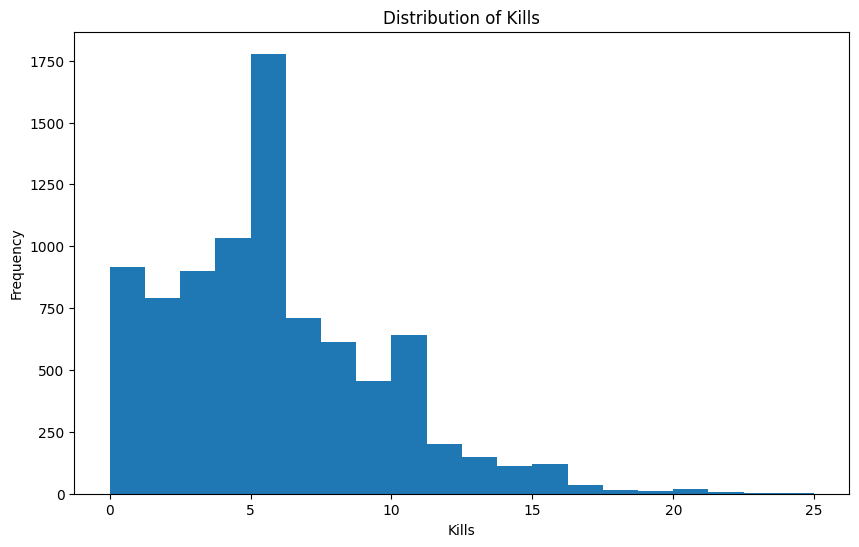

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(players['kills'], bins=20)
plt.title('Distribution of Kills')
plt.xlabel('Kills')
plt.ylabel('Frequency')
plt.show()

C:\Users\MWOfficeDesktop\AppData\Local\Temp\ipykernel_65656\2679703142.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot([hero_kill_data[hero_kill_data['hero_id']==hero]['kills'] for hero in top_heroes],


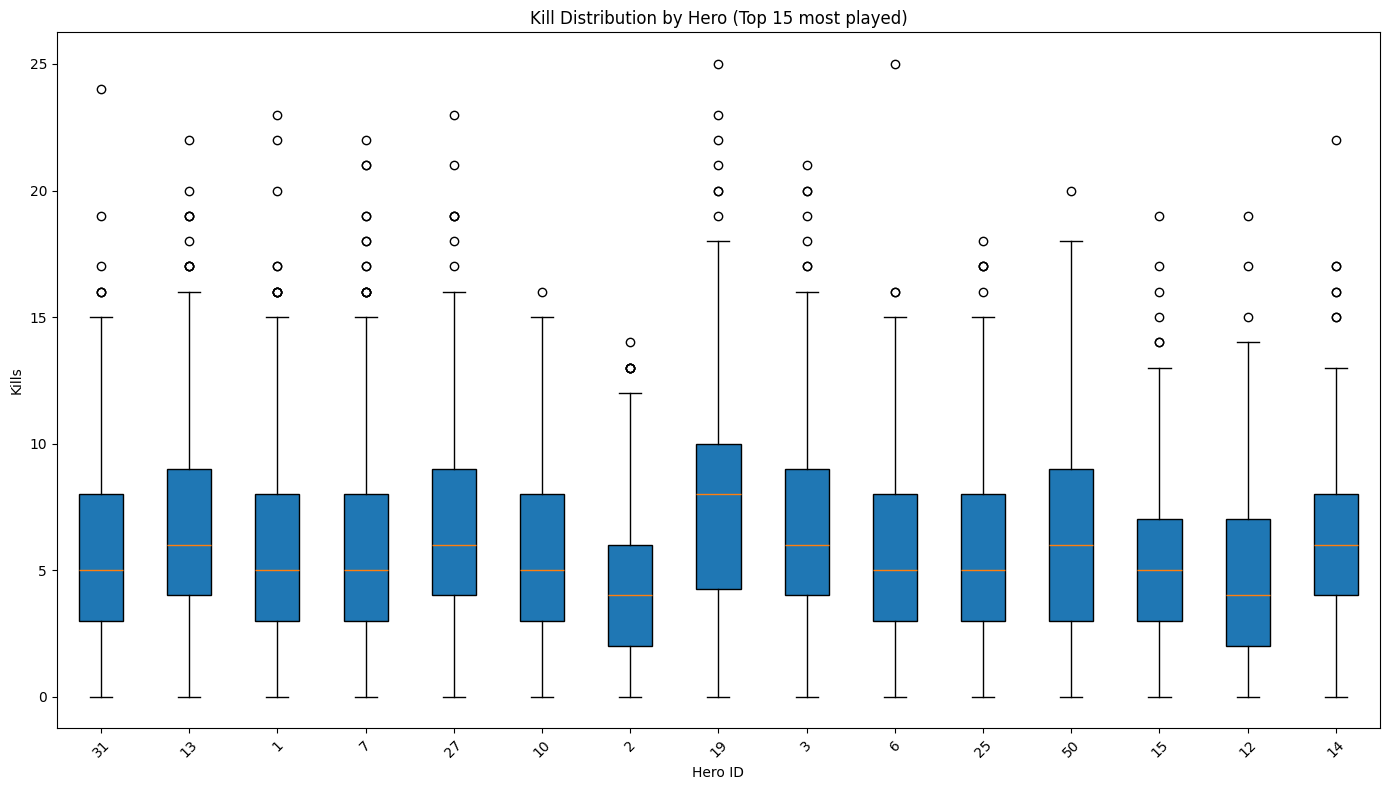

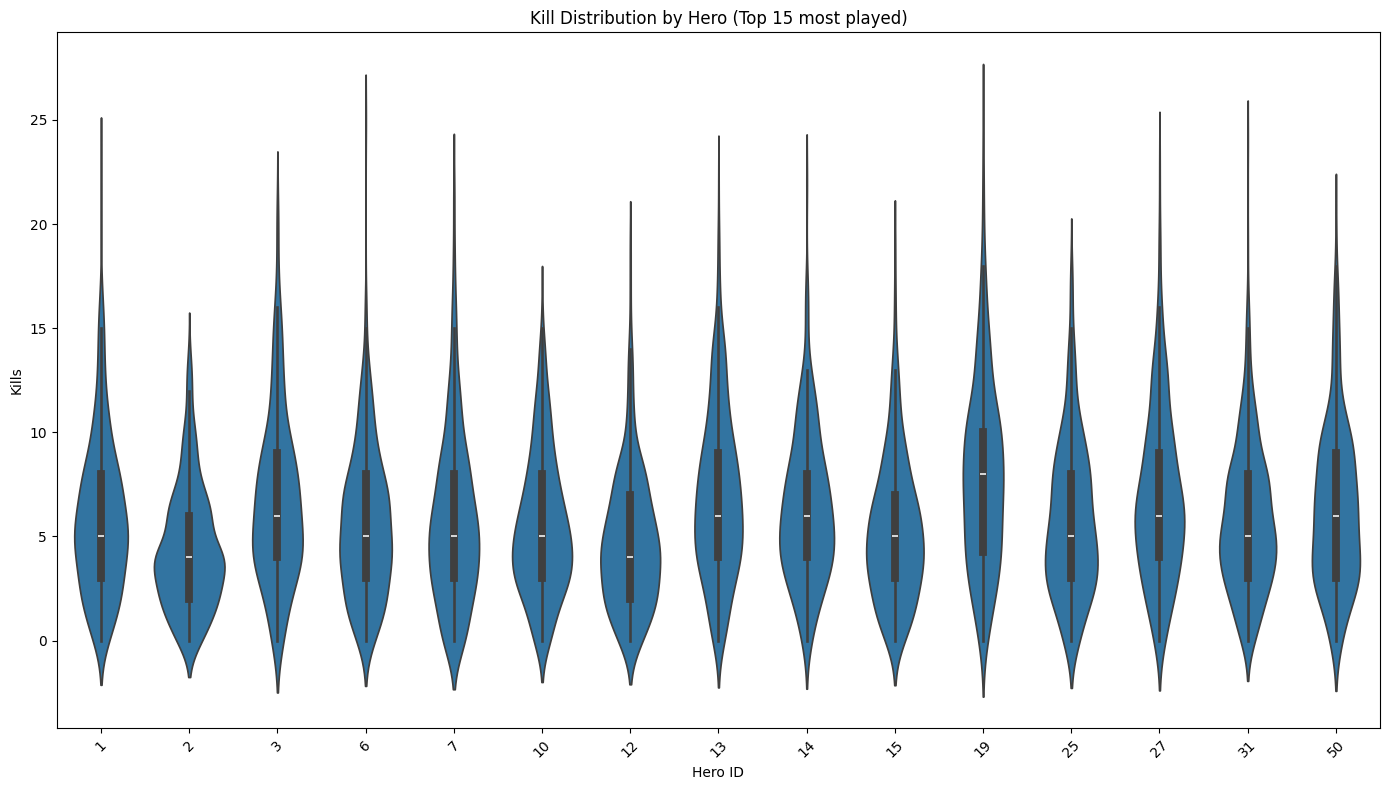

In [15]:
# Boxplot of kills by hero_id
plt.figure(figsize=(14, 8))

top_heroes = hero_counts.head(15).index.tolist()

hero_kill_data = players[players['hero_id'].isin(top_heroes)]

boxplot = plt.boxplot([hero_kill_data[hero_kill_data['hero_id']==hero]['kills'] for hero in top_heroes],
    labels=top_heroes, patch_artist=True)
plt.title('Kill Distribution by Hero (Top 15 most played)')
plt.xlabel('Hero ID')
plt.ylabel('Kills')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Violin plot 
import seaborn as sns
plt.figure(figsize=(14, 8))
sns.violinplot(x='hero_id', y='kills', data=hero_kill_data)
plt.title('Kill Distribution by Hero (Top 15 most played)')
plt.xlabel('Hero ID')
plt.ylabel('Kills')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\MWOfficeDesktop\AppData\Local\Temp\ipykernel_65656\3769415209.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot([hero_kill_data[hero_kill_data['hero_id']==hero]['deaths'] for hero in top_heroes],


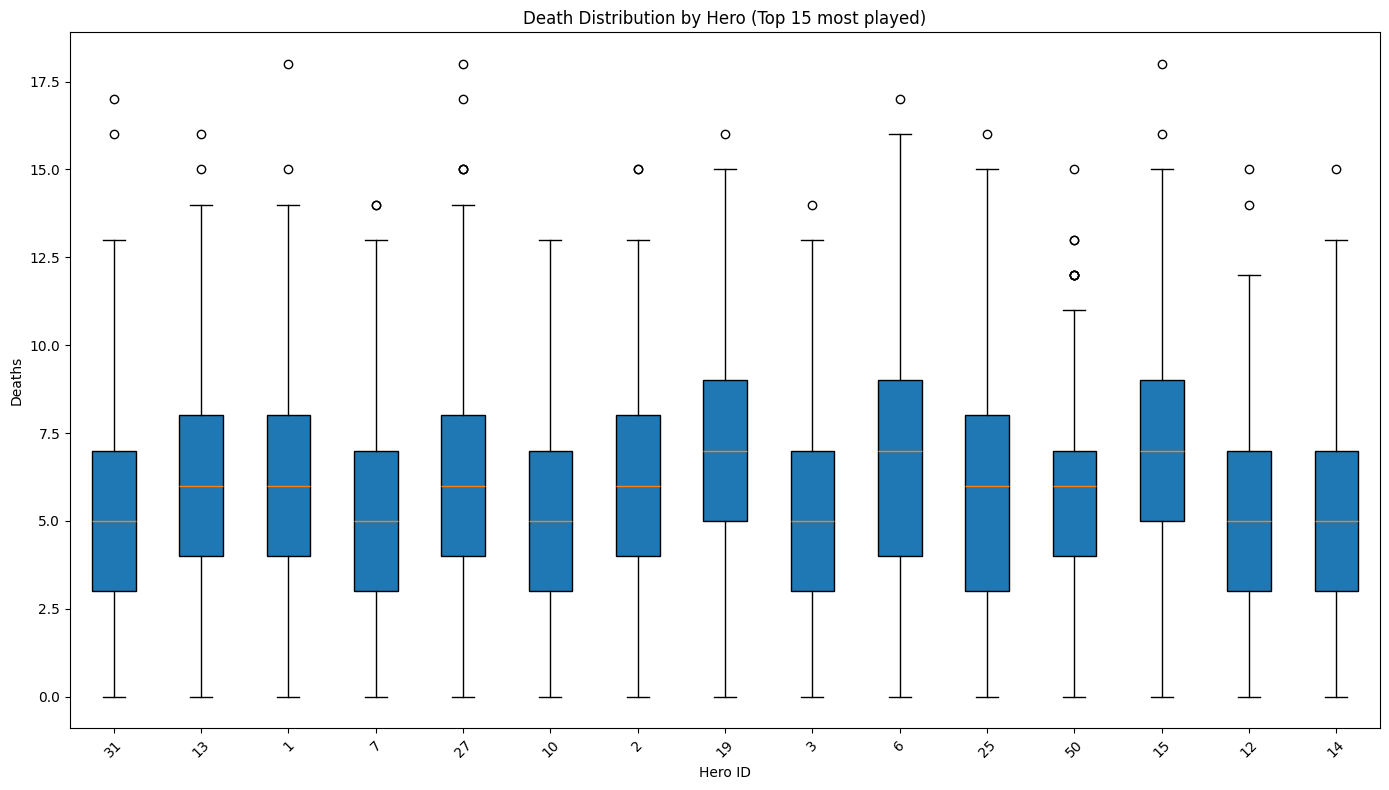

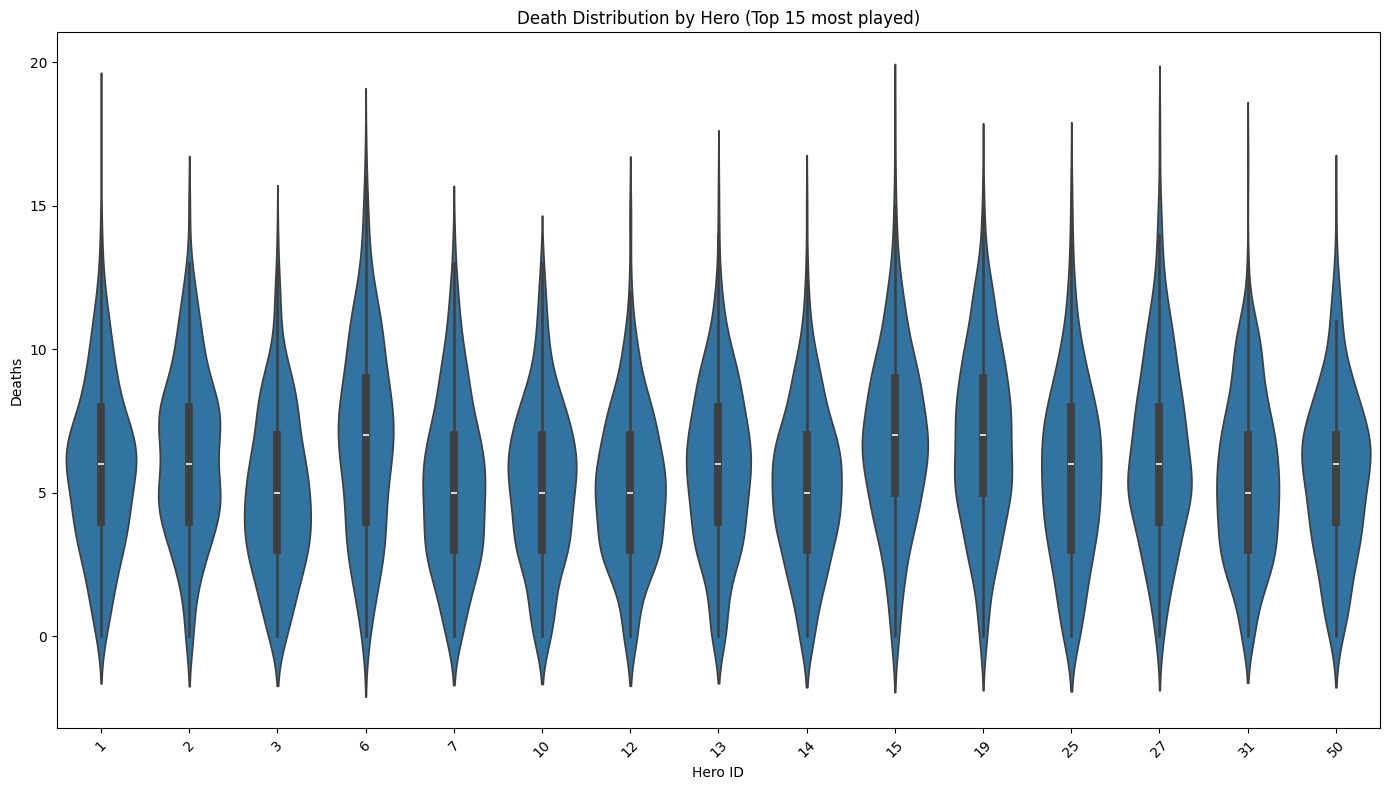

In [16]:
# Boxplot of kills by hero_id
plt.figure(figsize=(14, 8))

top_heroes = hero_counts.head(15).index.tolist()

hero_kill_data = players[players['hero_id'].isin(top_heroes)]

boxplot = plt.boxplot([hero_kill_data[hero_kill_data['hero_id']==hero]['deaths'] for hero in top_heroes],
    labels=top_heroes, patch_artist=True)
plt.title('Death Distribution by Hero (Top 15 most played)')
plt.xlabel('Hero ID')
plt.ylabel('Deaths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Violin plot 
import seaborn as sns
plt.figure(figsize=(14, 8))
sns.violinplot(x='hero_id', y='deaths', data=hero_kill_data)
plt.title('Death Distribution by Hero (Top 15 most played)')
plt.xlabel('Hero ID')
plt.ylabel('Deaths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Average K:D ratio by hero:
hero_id
3     2.196190
7     1.738943
13    1.730458
14    1.727382
50    1.665936
25    1.625954
31    1.568232
10    1.555715
19    1.546456
27    1.513552
1     1.429212
12    1.278504
6     1.205724
15    1.056351
2     0.915642
Name: kd_ratio, dtype: float64


C:\Users\MWOfficeDesktop\AppData\Local\Temp\ipykernel_65656\2105120946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hero_kill_data['kd_ratio'] = hero_kill_data['kills'] / hero_kill_data['deaths'].replace(0, 1)  # Avoid division by zero
C:\Users\MWOfficeDesktop\AppData\Local\Temp\ipykernel_65656\2105120946.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot([hero_kill_data[hero_kill_data['hero_id']==hero]['kd_ratio'] for hero in top_heroes],


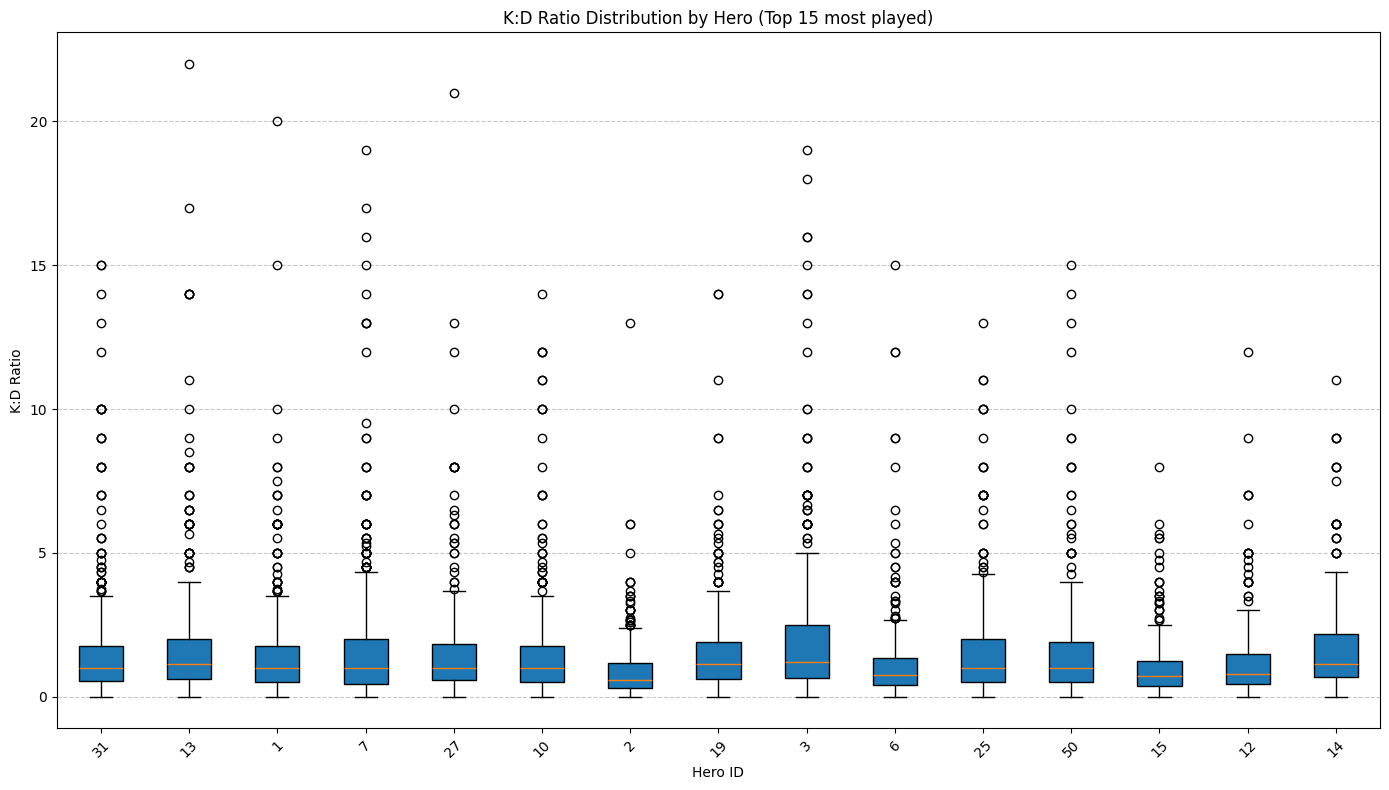

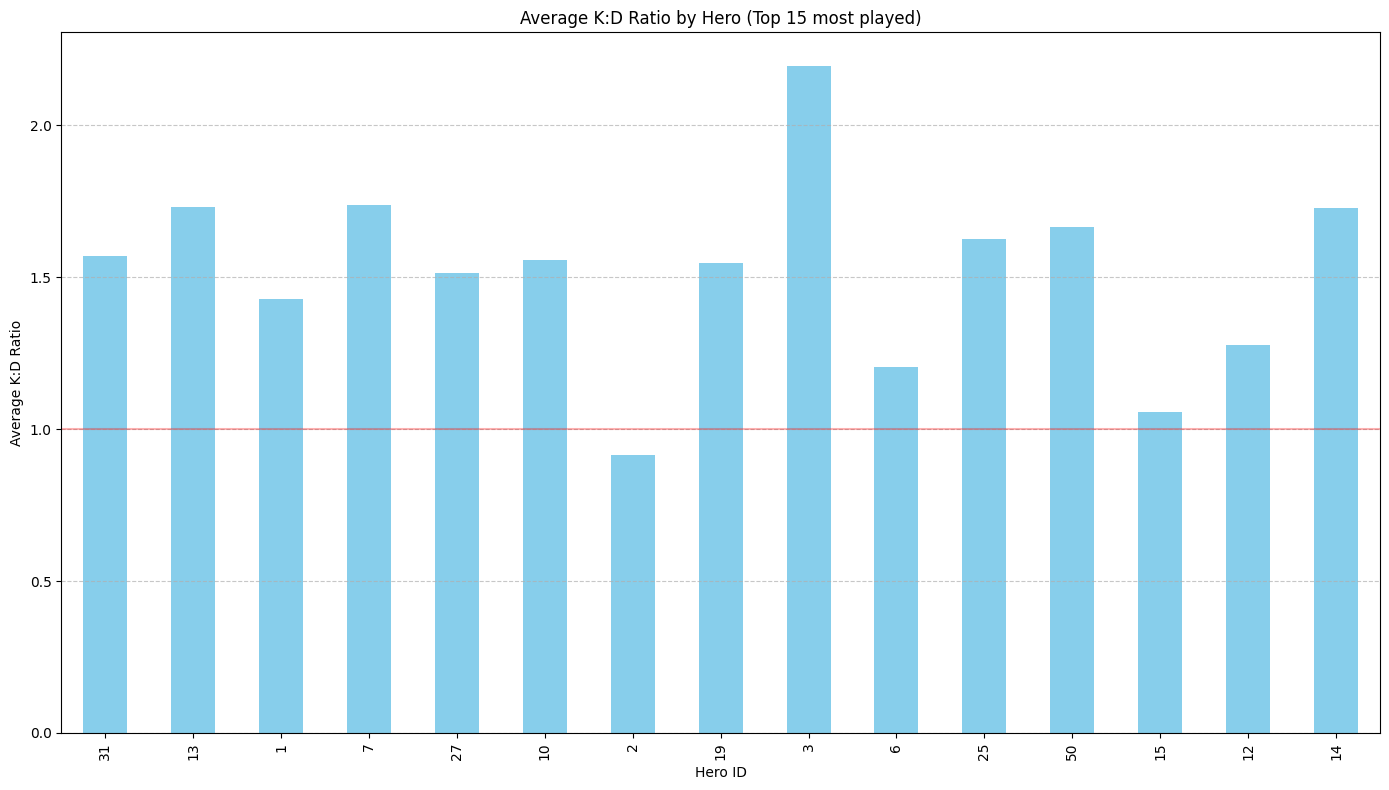

In [17]:
hero_kill_data['kd_ratio'] = hero_kill_data['kills'] / hero_kill_data['deaths'].replace(0, 1)  # Avoid division by zero

# Calculate average K:D ratio by hero
hero_kd_avg = hero_kill_data.groupby('hero_id')['kd_ratio'].mean().sort_values(ascending=False)
print("Average K:D ratio by hero:")
print(hero_kd_avg)

# Boxplot for K:D ratio
plt.figure(figsize=(14, 8))
boxplot = plt.boxplot([hero_kill_data[hero_kill_data['hero_id']==hero]['kd_ratio'] for hero in top_heroes],
                     labels=top_heroes, patch_artist=True)
plt.title('K:D Ratio Distribution by Hero (Top 15 most played)')
plt.xlabel('Hero ID')
plt.ylabel('K:D Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Bar chart of average K:D ratio
plt.figure(figsize=(14, 8))
hero_kd_avg = hero_kill_data.groupby('hero_id')['kd_ratio'].mean().reindex(top_heroes)
hero_kd_avg.plot(kind='bar', color='skyblue')
plt.title('Average K:D Ratio by Hero (Top 15 most played)')
plt.xlabel('Hero ID')
plt.ylabel('Average K:D Ratio')
plt.axhline(y=1.0, color='r', linestyle='-', alpha=0.3)  # Reference line for K:D = 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [39]:
# Process all unique players
# Uncomment the following code to process all players

def process_all_players(player_ids, batch_size=50, max_workers_per_batch=50, timeout=30):
    """
    Process all players in batches
    
    Parameters:
    - player_ids: List of player IDs to process
    - batch_size: Number of players to process in each batch
    - max_workers_per_batch: Number of concurrent workers per batch
    - timeout: Request timeout in seconds
    
    Returns:
    - Tuple of (player_stats_df, player_hero_stats_df)
    """
    num_batches = (len(player_ids) + batch_size - 1) // batch_size  # Ceiling division
    
    all_player_stats = []
    all_player_hero_stats = []
    successful_players = 0
    failed_players = 0
    
    print(f"Processing {len(player_ids)} players in {num_batches} batches of {batch_size}")
    
    total_start_time = time.time()
    
    for batch_num in range(num_batches):
        start_idx = batch_num * batch_size
        end_idx = min(start_idx + batch_size, len(player_ids))
        batch_players = player_ids[start_idx:end_idx]
        
        print(f"\nProcessing batch {batch_num+1}/{num_batches} with {len(batch_players)} players")
        
        batch_start_time = time.time()
        
        # Process batch
        batch_player_stats, batch_player_hero_stats = process_player_stats_parallel(
            batch_players, 
            max_workers=max_workers_per_batch,
            timeout=timeout
        )
        
        batch_end_time = time.time()
        batch_duration = batch_end_time - batch_start_time
        
        # Count successful and failed players
        batch_successful = len(batch_player_stats) if not batch_player_stats.empty else 0
        batch_failed = len(batch_players) - batch_successful
        
        successful_players += batch_successful
        failed_players += batch_failed
        
        print(f"Batch {batch_num+1} completed in {batch_duration:.2f} seconds")
        print(f"  Players processed in batch: {batch_successful}/{len(batch_players)}")
        
        # Add results to overall lists if not empty
        if not batch_player_stats.empty:
            all_player_stats.append(batch_player_stats)
            all_player_hero_stats.append(batch_player_hero_stats)
            print(f"  Hero stats entries in batch: {len(batch_player_hero_stats)}")
    
    # Combine all batches
    if all_player_stats:
        combined_player_stats = pd.concat(all_player_stats, ignore_index=True)
        combined_player_hero_stats = pd.concat(all_player_hero_stats, ignore_index=True)
        
        total_end_time = time.time()
        total_duration = total_end_time - total_start_time
        
        print("\nProcessing Summary:")
        print(f"Total time: {total_duration:.2f} seconds")
        print(f"Successful players: {successful_players}/{len(player_ids)} ({successful_players/len(player_ids)*100:.1f}%)")
        print(f"Failed players: {failed_players}")
        print(f"Total hero entries: {len(combined_player_hero_stats)}")
        
        return combined_player_stats, combined_player_hero_stats
    else:
        print("No player data was successfully processed")
        return pd.DataFrame(), pd.DataFrame()




In [43]:
print(f"Processing all {len(unique_player_ids)} unique players")

# Process all players in batches
df_player_stats, df_player_hero_stats = process_all_players(
    unique_player_ids,
    batch_size=200,           # 200 players per batch
    max_workers_per_batch=25,  # 25 concurrent workers per batch
    timeout=30               # 30 second timeout per request
)

#Save the complete data to CSV files if processing was successful
if not df_player_stats.empty:
    df_player_stats.to_csv("v2_data/player_stats.csv", index=False)
    df_player_hero_stats.to_csv("v2_data/player_hero_stats.csv", index=False)
    print("Data saved to CSV files in v2_data folder")

Processing all 2433 unique players
Processing 2433 players in 13 batches of 200

Processing batch 1/13 with 200 players
Processing 200 players with 25 workers
Fetching stats for player 366829568
Fetching stats for player 65552385
Fetching stats for player 1743454214
Fetching stats for player 1877508105
Fetching stats for player 1055031308
Fetching stats for player 1844731916
Fetching stats for player 1911644178
Fetching stats for player 165560339
Fetching stats for player 105553938
Fetching stats for player 16318483
Fetching stats for player 27992086
Fetching stats for player 173907991
Fetching stats for player 123502615
Fetching stats for player 1090412566
Fetching stats for player 153149464
Fetching stats for player 1837383713
Fetching stats for player 1238974498
Fetching stats for player 127942689
Fetching stats for player 1132011566
Fetching stats for player 431104049
Fetching stats for player 31555634
Fetching stats for player 388251702
Fetching stats for player 445177910
Fetching

  0%|          | 0/200 [00:00<?, ?it/s]

Fetching stats for player 405946428
Fetching stats for player 37036096
Fetching stats for player 172638273
Fetching stats for player 339976259
Fetching stats for player 1776173125
Fetching stats for player 404054090
Fetching stats for player 327532620
Fetching stats for player 1900535887
Fetching stats for player 280649808
Fetching stats for player 145596499
Fetching stats for player 91373654
Fetching stats for player 1747017815
Fetching stats for player 1926422616
Fetching stats for player 143073372
Fetching stats for player 1875697758
Fetching stats for player 919887968
Fetching stats for player 1164034146
Fetching stats for player 318619753
Fetching stats for player 333815918
Fetching stats for player 111820919
Fetching stats for player 892272759
Fetching stats for player 64618621
Fetching stats for player 65650814
Fetching stats for player 58826881
Fetching stats for player 241565825
Fetching stats for player 327114883
Fetching stats for player 167698564
Fetching stats for player 1

  0%|          | 0/200 [00:00<?, ?it/s]

Fetching stats for player 79192770
Fetching stats for player 1115382466
Fetching stats for player 115729094
Fetching stats for player 294560455
Fetching stats for player 190120651
Fetching stats for player 86541004
Fetching stats for player 1041023693
Fetching stats for player 1041023693
Fetching stats for player 188441304
Fetching stats for player 1865605849
Fetching stats for player 74744539
Fetching stats for player 188441304
Fetching stats for player 1865605849
Fetching stats for player 74744539
Fetching stats for player 71729884
Fetching stats for player 1081131742
Fetching stats for player 71729884
Fetching stats for player 1081131742
Fetching stats for player 308888286
Fetching stats for player 1731846884
Fetching stats for player 308888286
Fetching stats for player 1731846884
Fetching stats for player 341295847
Fetching stats for player 190169838
Fetching stats for player 341295847
Fetching stats for player 190169838
Fetching stats for player 82985712
Fetching stats for player 

  0%|          | 0/200 [00:00<?, ?it/s]

Fetching stats for player 120923457
Fetching stats for player 1693648194
Fetching stats for player 205071683
Fetching stats for player 58418497
Fetching stats for player 1361339717
Fetching stats for player 209192265
Fetching stats for player 1897891148
Fetching stats for player 195257679
Fetching stats for player 1361339717
Fetching stats for player 209192265
Fetching stats for player 1897891148
Fetching stats for player 195257679
Fetching stats for player 1516971343
Fetching stats for player 1516971343
Fetching stats for player 1098827091
Fetching stats for player 1098827091
Fetching stats for player 108471637
Fetching stats for player 131999064
Fetching stats for player 108471637
Fetching stats for player 131999064
Fetching stats for player 1576723802
Fetching stats for player 1048356191
Fetching stats for player 1576723802
Fetching stats for player 1048356191
Fetching stats for player 384042337
Fetching stats for player 384042337
Fetching stats for player 1049955
Fetching stats for

  0%|          | 0/200 [00:00<?, ?it/s]

Fetching stats for player 348194858
Fetching stats for player 924969004
Fetching stats for player 193701934
Fetching stats for player 951978031
Fetching stats for player 104859703
Fetching stats for player 997124152
Fetching stats for player 1111468102
Fetching stats for player 1270196295
Fetching stats for player 1847633996
Fetching stats for player 1599940693
Fetching stats for player 1299785813
Fetching stats for player 1599940693
Fetching stats for player 1299785813
Fetching stats for player 176007261
Fetching stats for player 211347551
Fetching stats for player 176007261
Fetching stats for player 211347551
Fetching stats for player 9398369
Fetching stats for player 9398369
Fetching stats for player 870778979
Fetching stats for player 870778979
Fetching stats for player 1229219946
Fetching stats for player 1229219946
Fetching stats for player 33327211
Fetching stats for player 33327211
Fetching stats for player 170477675
Fetching stats for player 1862559855
Fetching stats for playe

  0%|          | 0/200 [00:00<?, ?it/s]

Fetching stats for player 838322891
Fetching stats for player 54151884
Fetching stats for player 350210766
Fetching stats for player 392071891
Fetching stats for player 1325468376
Fetching stats for player 1389783772
Fetching stats for player 5180125
Fetching stats for player 76851934
Fetching stats for player 1018546912
Fetching stats for player 77834977
Fetching stats for player 187501288
Fetching stats for player 1857243884
Fetching stats for player 1204407031
Fetching stats for player 1828547322
Fetching stats for player 1124199166
Fetching stats for player 1124199166
Fetching stats for player 118811391
Fetching stats for player 118811391
Fetching stats for player 891136769
Fetching stats for player 891136769
Fetching stats for player 34294529
Fetching stats for player 34294529
Fetching stats for player 149433090
Fetching stats for player 149433090
Fetching stats for player 893758211
Fetching stats for player 893758211
Fetching stats for player 116984580
Fetching stats for player 1

  0%|          | 0/200 [00:00<?, ?it/s]

Fetching stats for player 293506436
Fetching stats for player 427765127
Fetching stats for player 427765127
Fetching stats for player 356216207
Fetching stats for player 97652111
Fetching stats for player 356216207
Fetching stats for player 97652111
Fetching stats for player 320744850
Fetching stats for player 207449491
Fetching stats for player 320744850
Fetching stats for player 207449491
Fetching stats for player 102591890
Fetching stats for player 181456277
Fetching stats for player 102591890
Fetching stats for player 181456277
Fetching stats for player 373624213
Fetching stats for player 373624213
Fetching stats for player 106589590
Fetching stats for player 106589590
Fetching stats for player 444231065
Fetching stats for player 444231065
Fetching stats for player 863727003
Fetching stats for player 882994587
Fetching stats for player 863727003
Fetching stats for player 882994587
Fetching stats for player 207932830
Fetching stats for player 207932830
Fetching stats for player 2199

  0%|          | 0/200 [00:00<?, ?it/s]

Fetching stats for player 175656930
Fetching stats for player 219590629
Fetching stats for player 219590629
Fetching stats for player 1054961641
Fetching stats for player 1054961641
Fetching stats for player 329035753
Fetching stats for player 329035753
Fetching stats for player 1858908139
Fetching stats for player 1040199668
Fetching stats for player 1858908139
Fetching stats for player 1040199668
Fetching stats for player 864653306
Fetching stats for player 907210747
Fetching stats for player 864653306
Fetching stats for player 907210747
Fetching stats for player 79802381
Fetching stats for player 864874512
Fetching stats for player 79802381
Fetching stats for player 864874512
Fetching stats for player 110088215
Fetching stats for player 1100197915
Fetching stats for player 110088215
Fetching stats for player 1100197915
Fetching stats for player 28241947
Fetching stats for player 28241947
Fetching stats for player 50794527
Fetching stats for player 121770017
Fetching stats for player

  0%|          | 0/200 [00:00<?, ?it/s]

Fetching stats for player 998920845
Fetching stats for player 27406990
Fetching stats for player 1853002387
Fetching stats for player 1084207767
Fetching stats for player 1905136282
Fetching stats for player 1853002387
Fetching stats for player 1084207767
Fetching stats for player 1905136282
Fetching stats for player 1871622814
Fetching stats for player 1871622814
Fetching stats for player 1168757409
Fetching stats for player 1168757409
Fetching stats for player 1830122145
Fetching stats for player 1830122145
Fetching stats for player 852071075
Fetching stats for player 852071075
Fetching stats for player 27374245
Fetching stats for player 1855820454
Fetching stats for player 27374245
Fetching stats for player 1855820454
Fetching stats for player 1840902834
Fetching stats for player 1110282931
Fetching stats for player 1840902834
Fetching stats for player 1110282931
Fetching stats for player 29651636
Fetching stats for player 29651636
Fetching stats for player 1737585336
Fetching stats

  0%|          | 0/200 [00:00<?, ?it/s]

Fetching stats for player 199865596
Fetching stats for player 1773696253
Fetching stats for player 1773696253
Fetching stats for player 246740231
Fetching stats for player 848524552
Fetching stats for player 246740231
Fetching stats for player 848524552
Fetching stats for player 314873097
Fetching stats for player 314873097
Fetching stats for player 234001674
Fetching stats for player 912733459
Fetching stats for player 234001674
Fetching stats for player 912733459
Fetching stats for player 1072428308
Fetching stats for player 1072428308
Fetching stats for player 119559450
Fetching stats for player 119559450
Fetching stats for player 254940443
Fetching stats for player 254940443
Fetching stats for player 1265800476
Fetching stats for player 1807725850
Fetching stats for player 1910633763
Fetching stats for player 1265800476
Fetching stats for player 1807725850
Fetching stats for player 1910633763
Fetching stats for player 51991843
Fetching stats for player 51991843
Fetching stats for p

  0%|          | 0/200 [00:00<?, ?it/s]

Fetching stats for player 230307735
Fetching stats for player 1278687134
Fetching stats for player 105060266
Fetching stats for player 105060266
Fetching stats for player 62920623
Fetching stats for player 180967344
Fetching stats for player 62920623
Fetching stats for player 180967344
Fetching stats for player 1275451318
Fetching stats for player 1275451318
Fetching stats for player 1383897017
Fetching stats for player 159471545
Fetching stats for player 1383897017
Fetching stats for player 159471545
Fetching stats for player 838719419
Fetching stats for player 432805820
Fetching stats for player 838719419
Fetching stats for player 432805820
Fetching stats for player 169588667
Fetching stats for player 169588667
Fetching stats for player 1150269374
Fetching stats for player 1150269374
Fetching stats for player 1742174145
Fetching stats for player 1742174145
Fetching stats for player 225105863
Fetching stats for player 225105863
Fetching stats for player 1190500296
Fetching stats for p

  0%|          | 0/200 [00:00<?, ?it/s]

Fetching stats for player 119994982
Fetching stats for player 1832319597
Fetching stats for player 1832319597
Fetching stats for player 104077933
Fetching stats for player 104077933
Fetching stats for player 1024834159
Fetching stats for player 81336943
Fetching stats for player 1024834159
Fetching stats for player 81336943
Fetching stats for player 1762450032
Fetching stats for player 154286701
Fetching stats for player 1762450032
Fetching stats for player 154286701
Fetching stats for player 155138676
Fetching stats for player 155138676
Fetching stats for player 1356683901
Fetching stats for player 1356683901
Fetching stats for player 1822530191
Fetching stats for player 1822530191
Fetching stats for player 487348881
Fetching stats for player 487348881
Fetching stats for player 1715337879
Fetching stats for player 32135834
Fetching stats for player 105044636
Fetching stats for player 1715337879
Fetching stats for player 32135834
Fetching stats for player 105044636
Fetching stats for p

  0%|          | 0/200 [00:00<?, ?it/s]

Fetching stats for player 1238293735
Fetching stats for player 279125228
Fetching stats for player 279125228
Fetching stats for player 898514158
Fetching stats for player 898514158
Fetching stats for player 463887599
Fetching stats for player 463887599
Fetching stats for player 151960816
Fetching stats for player 151960816
Fetching stats for player 1088068850
Fetching stats for player 1088068850
Fetching stats for player 234314999
Fetching stats for player 234314999
Fetching stats for player 335879417
Fetching stats for player 335879417
Fetching stats for player 914316537
Fetching stats for player 1869028605
Fetching stats for player 914316537
Fetching stats for player 1869028605
Fetching stats for player 113605886
Fetching stats for player 1019002118
Fetching stats for player 113605886
Fetching stats for player 1019002118
Fetching stats for player 881974538
Fetching stats for player 1280179474
Fetching stats for player 881974538
Fetching stats for player 1280179474
Fetching stats for 

  0%|          | 0/33 [00:00<?, ?it/s]

Fetching stats for player 1857896411
Fetching stats for player 130179038
Fetching stats for player 130179038
Fetching stats for player 62586848
Fetching stats for player 62586848
Fetching stats for player 157237227
Fetching stats for player 157237227
Fetching stats for player 915808246
Fetching stats for player 915808246
Fetching stats for player 149184503
Fetching stats for player 385605625
Fetching stats for player 149184503
Fetching stats for player 385605625
Fetching stats for player 1924308986
Fetching stats for player 1924308986
Completed with 0 errors out of 33 players
Batch 13 completed in 20.29 seconds
  Players processed in batch: 33/33
  Hero stats entries in batch: 625

Processing Summary:
Total time: 1109.71 seconds
Successful players: 2311/2433 (95.0%)
Failed players: 122
Total hero entries: 44104
Data saved to CSV files in v2_data folder
Completed with 0 errors out of 33 players
Batch 13 completed in 20.29 seconds
  Players processed in batch: 33/33
  Hero stats entries 

In [48]:
def retry_failed_players(original_player_set = "v2_data/players.csv", completed_player_stats = "v2_data/player_stats.csv"):
    """
    Identifies player IDs that failed to process and retries them
    
    This function:
    1. Finds all player IDs in the original dataset that aren't in the processed results
    2. Retries processing these failed players in smaller batches
    3. Combines the retry results with the original results
    4. Saves the updated complete dataset
    """
    print("Starting retry process for failed player IDs...")
    

    try:
        # Load the original unique player IDs from the match data
        original_players_df = pd.read_csv(original_player_set)
        all_original_players = set(original_players_df['account_id'].astype(str).unique())
        print(f"Total unique players in original data: {len(all_original_players)}")
    
        # load the processed player stats
        processed_stats = pd.read_csv(completed_player_stats)
        processed_player_ids = set(processed_stats['account_id'].astype(str))
        print(f"Successfully processed players: {len(processed_player_ids)}")
        
        # Find failed players (in original set but not in processed set)
        failed_player_ids = list(all_original_players - processed_player_ids)
        print(f"Found {len(failed_player_ids)} failed player IDs to retry")
        
        if not failed_player_ids:
            print("No failed players to retry. All players were processed successfully.")
            return
            
        # Process the failed players with smaller batch size and more timeout
        print("\n--- Retrying failed players ---")
        retry_stats, retry_hero_stats = process_all_players(
            failed_player_ids,
            batch_size=50,            # Smaller batch size
            max_workers_per_batch=10,  # Fewer concurrent workers
            timeout=45                # Longer timeout
        )
        
        # Check if retry was successful
        if retry_stats.empty:
            print("Retry process didn't yield any successful results")
            return
            
        # Combine the retry results with the original results
        print("\nCombining retry results with original results...")
        
        # Load original hero stats
        processed_hero_stats = pd.read_csv("v2_data/player_hero_stats.csv")
        
        # Combine data
        combined_stats = pd.concat([processed_stats, retry_stats], ignore_index=True)
        combined_hero_stats = pd.concat([processed_hero_stats, retry_hero_stats], ignore_index=True)
        
        # Save the updated complete dataset
        combined_stats.to_csv("v2_data/player_stats_with_retries.csv", index=False)
        combined_hero_stats.to_csv("v2_data/player_hero_stats_with_retries.csv", index=False)
        
        # Calculate success rate
        total_success_count = len(combined_stats)
        success_rate = total_success_count / len(all_original_players) * 100
        
        print("\n--- Retry Summary ---")
        print(f"Original successful players: {len(processed_player_ids)}")
        print(f"Additional players from retry: {len(retry_stats)}")
        print(f"Total successful players: {total_success_count}/{len(all_original_players)} ({success_rate:.1f}%)")
        print(f"Total hero entries: {len(combined_hero_stats)}")
        print("Updated data saved to v2_data/player_stats_with_retries.csv and v2_data/player_hero_stats_with_retries.csv")
        
    except FileNotFoundError:
        print("Error: Processed data files not found. Make sure the main processing completed and saved files.")
    except Exception as e:
        print(f"Error during retry process: {e}")


In [49]:
# retrying failed players
print("started retrying failed players")
retry_failed_players()
print("stopped retrying failed players")

started retrying failed players
Starting retry process for failed player IDs...
Total unique players in original data: 2433
Successfully processed players: 2311
Found 122 failed player IDs to retry

--- Retrying failed players ---
Processing 122 players in 3 batches of 50

Processing batch 1/3 with 50 players
Processing 50 players with 10 workers
Fetching stats for player 1049947751
Fetching stats for player 149948606
Fetching stats for player 302854054
Fetching stats for player 1737585336
Fetching stats for player 1243852454
Fetching stats for player 890100186
Fetching stats for player 920224746
Fetching stats for player 392071891
Fetching stats for player 145466276
Fetching stats for player 1204407031


  0%|          | 0/50 [00:00<?, ?it/s]

Fetching stats for player 1118378582
Fetching stats for player 1893591842
Fetching stats for player 1893591842
Fetching stats for player 74864964
Fetching stats for player 838547936
Fetching stats for player 74864964
Fetching stats for player 838547936
Fetching stats for player 838757715
Fetching stats for player 838757715
Fetching stats for player 1299785813
Fetching stats for player 1299785813
Fetching stats for player 978120226
Fetching stats for player 978120226
Fetching stats for player 183599462
Fetching stats for player 1006448332
Fetching stats for player 183599462
Fetching stats for player 1006448332
Fetching stats for player 323196641
Fetching stats for player 323196641
Fetching stats for player 225764206
Fetching stats for player 308802177
Fetching stats for player 225764206
Fetching stats for player 308802177
Fetching stats for player 113605886
Fetching stats for player 113605886
Fetching stats for player 84379844
Fetching stats for player 325983748
Fetching stats for playe

  0%|          | 0/50 [00:00<?, ?it/s]

Fetching stats for player 149433090
Fetching stats for player 324082108
Fetching stats for player 1528300514
Fetching stats for player 1528300514
Fetching stats for player 1752792693
Fetching stats for player 1752792693
Fetching stats for player 39226397
Fetching stats for player 39226397
Fetching stats for player 133544364
Fetching stats for player 1178865773
Fetching stats for player 133544364
Fetching stats for player 1178865773
Fetching stats for player 1869342880
Fetching stats for player 1869342880
Fetching stats for player 366769479
Fetching stats for player 1850135240
Fetching stats for player 366769479
Fetching stats for player 1850135240
Fetching stats for player 335909756
Fetching stats for player 335909756
Fetching stats for player 1158295817
Fetching stats for player 1158295817
Fetching stats for player 311528474
Fetching stats for player 311528474
Fetching stats for player 50794527
Fetching stats for player 1905136282
Fetching stats for player 50794527
Fetching stats for 

  0%|          | 0/22 [00:00<?, ?it/s]

Fetching stats for player 1753134484
Fetching stats for player 1842303299
Fetching stats for player 1842303299
Fetching stats for player 128710540
Fetching stats for player 128710540
Fetching stats for player 303927922
Fetching stats for player 303927922
Fetching stats for player 395566021
Fetching stats for player 395566021
Fetching stats for player 260063577
Fetching stats for player 1250734421
Fetching stats for player 280138668
Fetching stats for player 260063577
Fetching stats for player 1250734421
Fetching stats for player 280138668
Fetching stats for player 1315384189
Fetching stats for player 1180548075
Fetching stats for player 116984580
Fetching stats for player 1315384189
Fetching stats for player 1180548075
Fetching stats for player 116984580
Fetching stats for player 95718964
Fetching stats for player 95718964
Completed with 0 errors out of 22 players
Batch 3 completed in 10.03 seconds
  Players processed in batch: 22/22
  Hero stats entries in batch: 421

Processing Summa